- In this notebook we compute popular maesure Risks such as Value at Risk(VaR) and Conditional VaR(CVaR), using historical stock data, parametric fitting and finally Monte Carlo Simulations. We extract stock data using the yfinance package.
- For the first part, we ignore asset correlations, and fit a univariate distribution to the aggregated portfolio returns. In the second part we use multivariate distributions.
- The goals are:
    - Fit historical data to normal and t distrib'utions, and compare their risk metric predictions.
    - Compare the effect of asset correlations by fitting the data to a multivariate distribution, including:
        

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [41]:
import pandas as pd
import yfinance as yf
import time

tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2000-01-01'
end_date = '2019-12-01'

adj_close_data = {}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())


                               AAPL       MSFT  GOOG      NVDA      AMZN
Date                                                                    
2000-01-03 00:00:00-05:00  0.841048  35.726723   NaN  0.089425  4.468750
2000-01-04 00:00:00-05:00  0.770139  34.519867   NaN  0.087038  4.096875
2000-01-05 00:00:00-05:00  0.781408  34.883846   NaN  0.084172  3.487500
2000-01-06 00:00:00-05:00  0.713787  33.715286   NaN  0.078680  3.278125
2000-01-07 00:00:00-05:00  0.747598  34.155888   NaN  0.079994  3.478125


In [42]:
data.tail()

,AAPL,MSFT,GOOG,NVDA,AMZN
Date,,,,,
2019-11-22 00:00:00-05:00,63.295082,142.532700,64.384285,5.245522,87.286003
2019-11-25 00:00:00-05:00,64.404907,144.095291,64.948441,5.502214,88.692001
2019-11-26 00:00:00-05:00,63.901978,144.857529,65.289406,5.397498,89.847000
2019-11-27 00:00:00-05:00,64.760330,145.133881,65.261574,5.432345,90.925499
2019-11-29 00:00:00-05:00,64.617676,144.238205,64.862450,5.395008,90.040001


In [43]:
data.shape

(5010, 5)

C:\Users\manij\AppData\Local\Temp\ipykernel_63224\2207924783.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = data.resample('M').last().pct_change().dropna()


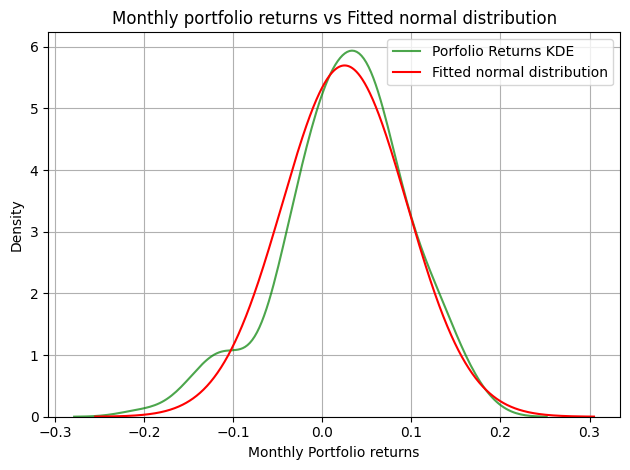

In [44]:
# returns = data.pct_change().dropna()
returns = data.resample('M').last().pct_change().dropna()

# Portfolio weights (equal weights as example)
weights = np.array([1/len(tickers)] * len(tickers))

# Portfolio daily returns -
portfolio_returns = returns.dot(weights)
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()
import seaborn as sns
sns.kdeplot(portfolio_returns, color='green', fill=False, alpha=0.7, label='Porfolio Returns KDE')
from scipy.stats import norm
x=np.linspace(mean-4*std_dev,mean+4*std_dev,1000)
plt.plot(x,norm.pdf(x, mean, std_dev),'r-', label='Fitted normal distribution')
plt.title('Monthly portfolio returns vs Fitted normal distribution')
plt.xlabel('Monthly Portfolio returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
returns.head()

,AAPL,MSFT,GOOG,NVDA,AMZN
Date,,,,,
2004-09-30 00:00:00-04:00,0.123514,0.012820,0.265996,0.165333,0.071316
2004-10-31 00:00:00-04:00,0.352258,0.011573,0.470988,-0.003446,-0.164709
2004-11-30 00:00:00-05:00,0.279580,0.068318,-0.045426,0.322052,0.162613
2004-12-31 00:00:00-05:00,-0.039522,-0.003357,0.059402,0.231569,0.116179
2005-01-31 00:00:00-05:00,0.194099,-0.016467,0.014679,-0.027163,-0.024159


In [46]:
from scipy.stats import shapiro
stat, p_value = shapiro(portfolio_returns)
print(f"Shapiro-Wilk p-value: {p_value:.4f}")


Shapiro-Wilk p-value: 0.0115


In [47]:
returns.shape

(183, 5)

## It looks like a bad fit, and it underestimates the left tail. Nevertheless we compute our risk metrics as a preliminary first step

=== Portfolio Risk Metrics with Normal distribution (95% confidence) ===
Historical VaR: -0.1125
Parametric VaR: -0.0902
Monte Carlo VaR: -0.0913
Conditional VaR (CVaR): -0.1386


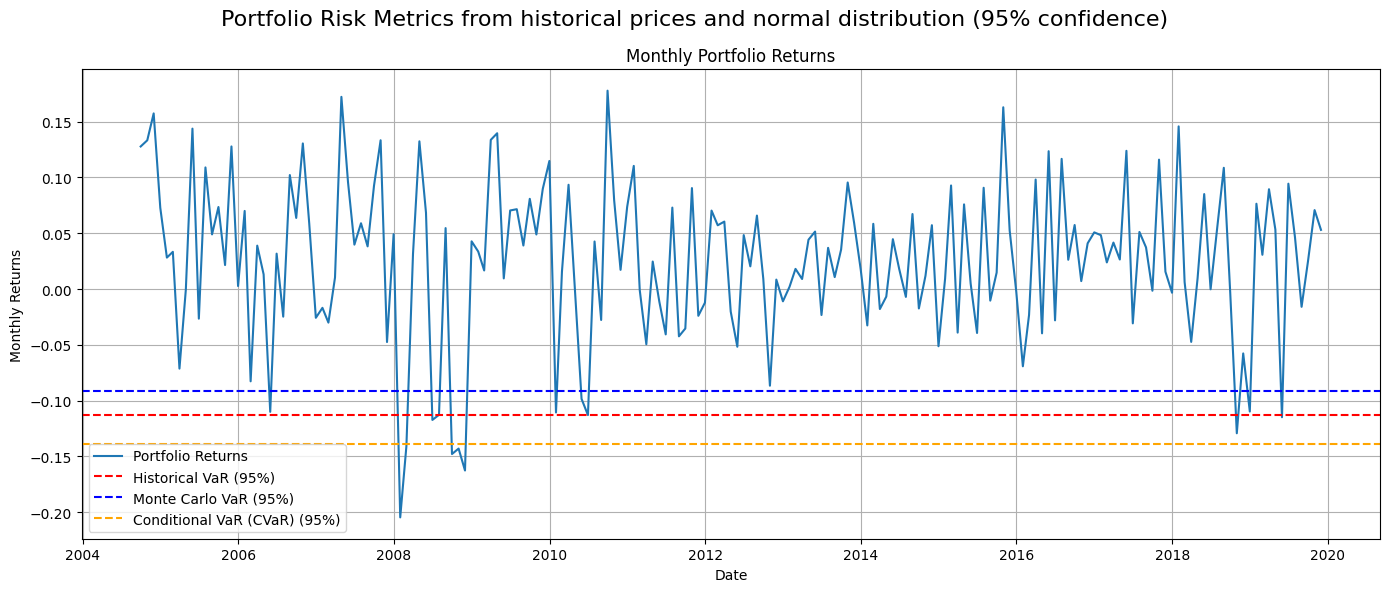

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


confidence_level=0.95
#  Historical VaR 
hist_VaR = np.percentile(portfolio_returns, (1-confidence_level)*100) #Note: Historical VaR doesnt depend on the distribution

#  Parametric VaR (Variance-Covariance, assuming normality) 

param_VaR = stats.norm.ppf(1 - confidence_level, mean, std_dev)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = np.random.normal(mean, std_dev, n_simulations)
mc_VaR = np.percentile(simulated_returns, (1-confidence_level)*100)

#  Conditional VaR (CVaR) 
CVaR = portfolio_returns[portfolio_returns <= hist_VaR].mean()

# Print results
print(f"=== Portfolio Risk Metrics with Normal distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Historical VaR: {hist_VaR:.4f}")
print(f"Parametric VaR: {param_VaR:.4f}")
print(f"Monte Carlo VaR: {mc_VaR:.4f}")
print(f"Conditional VaR (CVaR): {CVaR:.4f}")

# Visualization: rolling historical VaR over time 
window = 10  # 10-month rolling window
rolling_VaR = portfolio_returns.rolling(window).apply(
    lambda x: np.percentile(x, (1-confidence_level)*100), raw=False
)
plt.figure(figsize=(14, 6))
plt.suptitle(f"Portfolio Risk Metrics from historical prices and normal distribution ({confidence_level*100:.0f}% confidence)", fontsize=16)
# plt.subplot(1,2,1)
plt.plot(portfolio_returns.index, portfolio_returns, label='Portfolio Returns')
plt.axhline(y=hist_VaR, color='red', linestyle='--', label=f'Historical VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=mc_VaR, color='blue', linestyle='--', label=f'Monte Carlo VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=CVaR, color='orange', linestyle='--', label=f'Conditional VaR (CVaR) ({confidence_level*100:.0f}%)')
plt.title('Monthly Portfolio Returns')  
plt.xlabel('Date')
plt.ylabel('Monthly Returns') 
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.subplot(1,2,2)
# plt.plot(portfolio_returns.index, (1 + portfolio_returns).cumprod() - 1
# , label='Cumulative Portfolio Return')
# plt.plot(rolling_VaR, label=f'Rolling {window}d Historical VaR ({confidence_level*100:.0f}%)', color='red')

# plt.title('Portfolio Risk Over Time')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Return')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [49]:
returns.min()

AAPL   -0.329558
MSFT   -0.163357
GOOG   -0.184773
NVDA   -0.388889
AMZN   -0.304809
dtype: float64

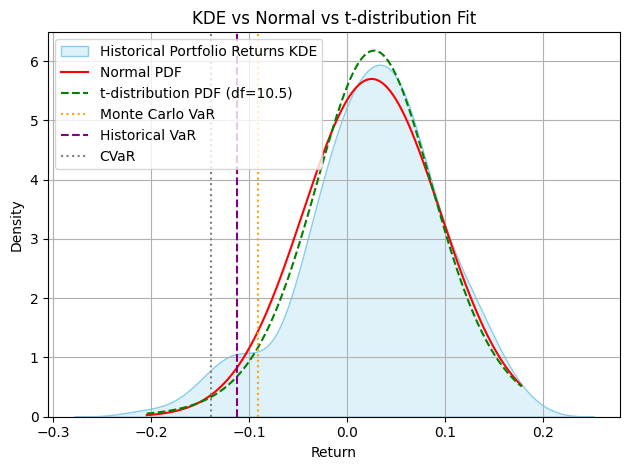

In [50]:
from scipy.stats import t

# Fit a t-distribution to portfolio returns
df, loc, scale = t.fit(portfolio_returns)

# Compare fit with KDE and normal
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)

sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Historical Portfolio Returns KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')
plt.axvline(mc_VaR, color='orange', linestyle=':', label='Monte Carlo VaR')
plt.axvline(hist_VaR, color='purple', linestyle='--', label='Historical VaR')
plt.axvline(CVaR, color='grey', linestyle=':', label='CVaR')

plt.title("KDE vs Normal vs t-distribution Fit")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#  Parametric VaR (Variance-Covariance, assuming t) 
param_VaR_mvn = stats.t.ppf(1 - confidence_level, df, loc, scale)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = loc + scale * np.random.standard_t(df, size=n_simulations)
mc_VaR_mvn = np.percentile(simulated_returns, (1-confidence_level)*100)

t_CVaR = simulated_returns[simulated_returns <= mc_VaR_mvn].mean()

# Print results
print(f"=== Portfolio Risk Metrics with t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Parametric VaR_mvn: {param_VaR_mvn:.4f}")
print(f"Monte Carlo VaR_mvn: {mc_VaR_mvn:.4f}")
print(f"Monte Carlo CVaR (95%): {t_CVaR:.4f}")



=== Portfolio Risk Metrics with t-distribution (95% confidence) ===
Parametric VaR_t: -0.0864
Monte Carlo VaR_t: -0.0882
Monte Carlo CVaR (95%): -0.1232


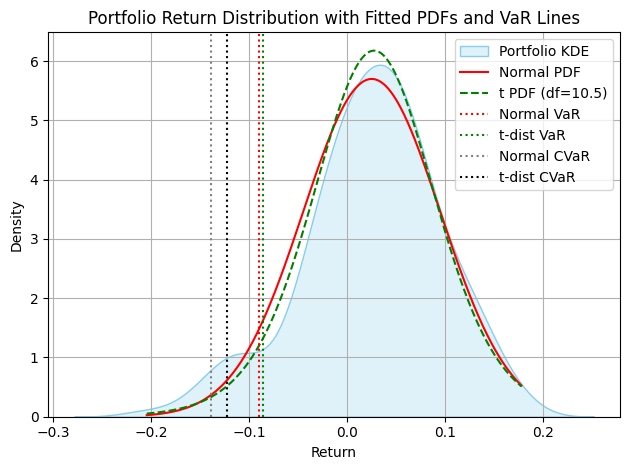

In [ ]:
# Dashboard plot
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't PDF (df={df:.1f})')

# VaR lines
plt.axvline(param_VaR, color='red', linestyle=':', label='Normal VaR')
plt.axvline(param_VaR_mvn, color='green', linestyle=':', label='t-dist VaR')
plt.axvline(CVaR,color='grey', linestyle=':', label = 'Normal CVaR')
plt.axvline(t_CVaR,color='black', linestyle=':', label = 't-dist CVaR')

plt.title('Portfolio Return Distribution with Fitted PDFs and VaR Lines')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Now lets study the stock prices individually, and see if their correlations have an impact on the final predictions

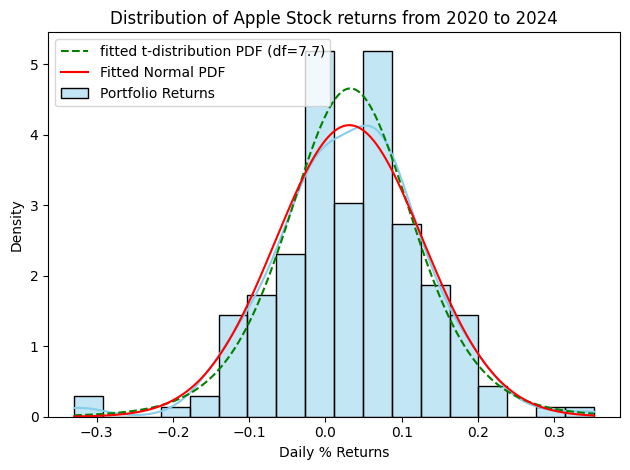

In [53]:
df,loc,scale = t.fit(returns['AAPL'])
fitted_norm=norm.fit(returns['AAPL'])
x= np.linspace(returns['AAPL'].min(), returns['AAPL'].max(), 1000)
sns.histplot(returns['AAPL'], kde=True, stat='density', color='skyblue', label='Portfolio Returns')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f'fitted t-distribution PDF (df={df:.1f})')
plt.plot(x, norm.pdf(x, loc=fitted_norm[0], scale=fitted_norm[1]), 'r-', label='Fitted Normal PDF')
plt.legend()
plt.title('Distribution of Apple Stock returns from 2020 to 2024')
plt.xlabel('Daily % Returns')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Text(0.5, 1.02, 'Pairplot of Stock Returns')

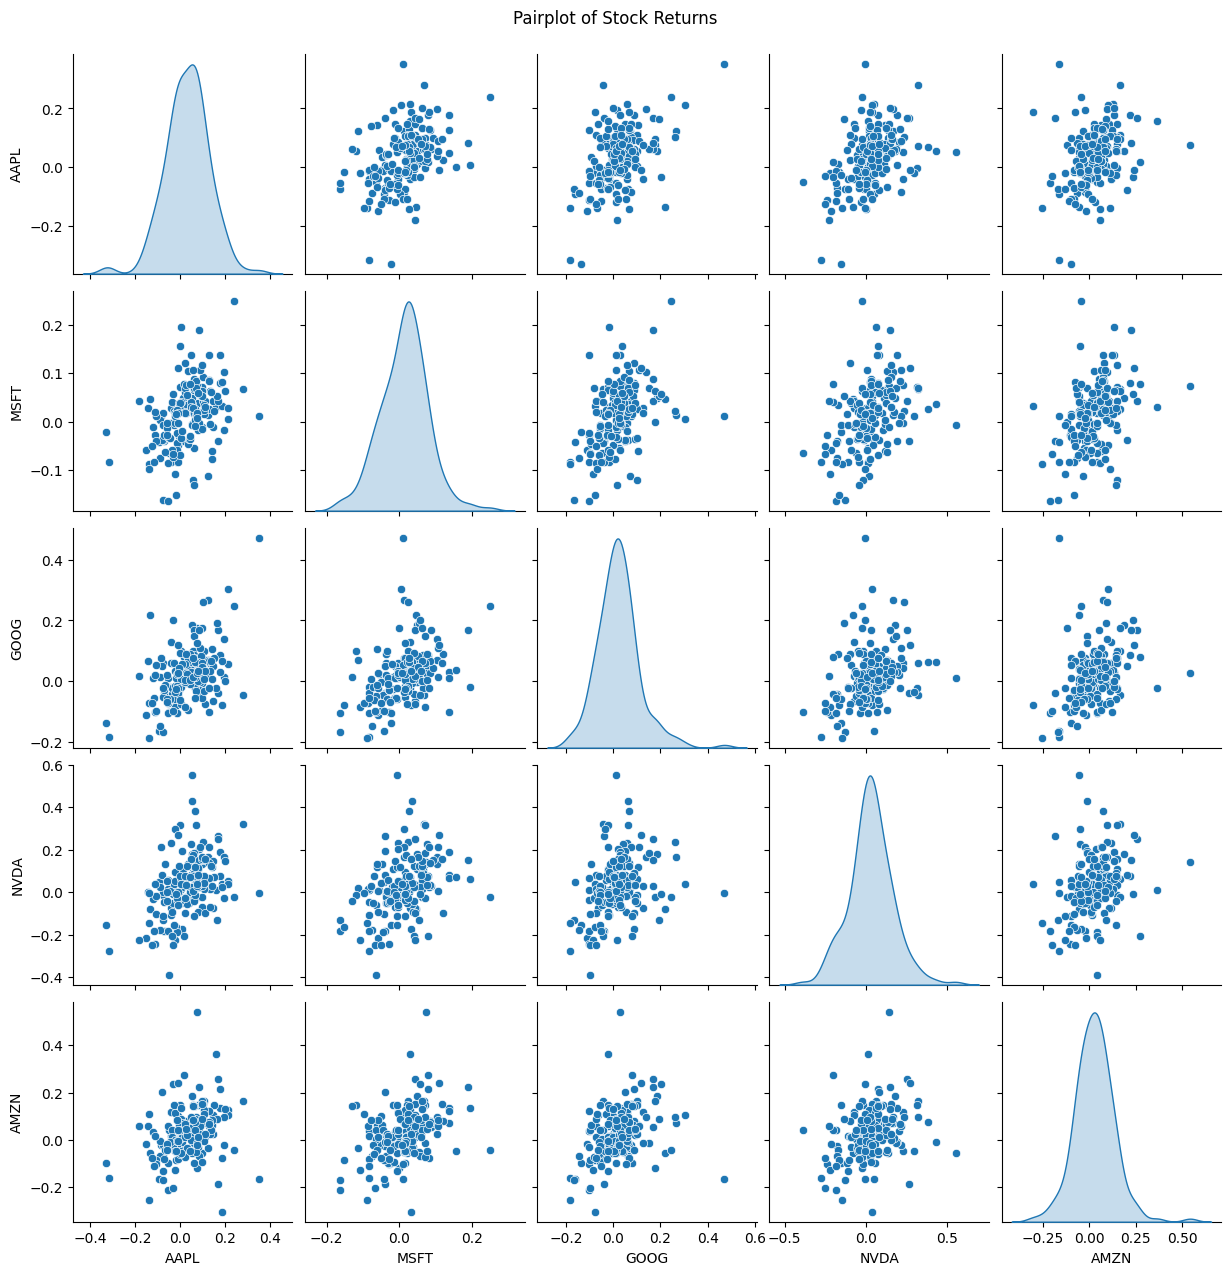

In [54]:
sns.pairplot(returns, diag_kind='kde', markers='o')
plt.suptitle('Pairplot of Stock Returns', y=1.02)

## As we can see, all the stocks are strongly correlated with one another

Text(0.5, 1.0, 'Correlation Matrix of Stock Returns')

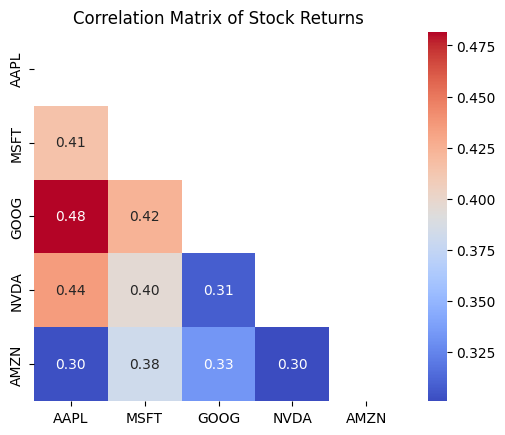

In [55]:

mask= np.triu(np.ones_like(returns.corr(), dtype=bool))
mask2 = returns.corr().abs() <= 1
sns.heatmap(returns.corr(), mask=mask & mask2,annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Stock Returns')

In [56]:
import numpy as np

n_samples = 10000
df = 3.7  # degrees of freedom (low df = fat tails)

# mean vector and covariance matrix from your return data
mean_vec = returns.mean().values           # shape: (n_assets,)
cov_matrix = returns.cov().values          # shape: (n_assets, n_assets)
n_assets = len(mean_vec)

# === Step 2: Simulate from multivariate normal ===
z = np.random.multivariate_normal(mean=mean_vec, cov=cov_matrix, size=n_samples)  # shape: (n_samples, n_assets)

#=== Step 3: Scale by sqrt of Gamma to get t-distribution ===
g = np.random.gamma(df / 2., 2. / df, size=n_samples)  # shape: (n_samples,)
scaling = np.sqrt(g)[:, None]  # reshape for broadcasting

# Simulate multivariate t
mvt_samples = mean_vec + (z - mean_vec) / scaling  # shape: (n_samples, n_assets)



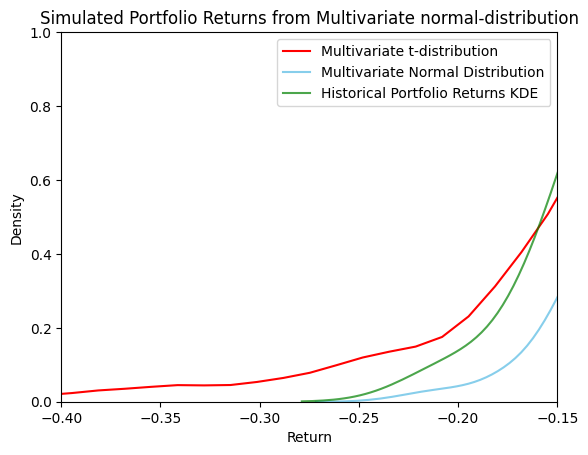

In [ ]:
#mvt_samples.shape
portfolio_returns_normal = mvt_samples.dot(weights)
portfolio_returns_normal= z.dot(weights)  # shape: (n_samples,)
df, loc, scale = t.fit(portfolio_returns_normal)
mean, std_dev = norm.fit(portfolio_returns_normal)
sns.kdeplot(portfolio_returns_normal,  color='red', label='Multivariate t-distribution')
sns.kdeplot(portfolio_returns_normal, color='skyblue', label='Multivariate Normal Distribution')
sns.kdeplot(portfolio_returns, color='green', fill=False, alpha=0.7, label='Historical Portfolio Returns KDE')
#plt.plot(x, , 'g--', label=f'Multivariate normal-distribution PDF (df={df:.1f})')
plt.title('Simulated Portfolio Returns from Multivariate normal-distribution')
plt.xlabel('Return')    
plt.ylabel('Density')
plt.xlim(-0.4, -0.15)
plt.ylim(0,1)
plt.legend()    
plt.show()  

### We take the normal distribution because it estimates the tail better

=== Portfolio Risk Metrics with Multivariate t-distribution (95% confidence) ===
VaR_t: -0.1267
CVaR_t: -0.2072


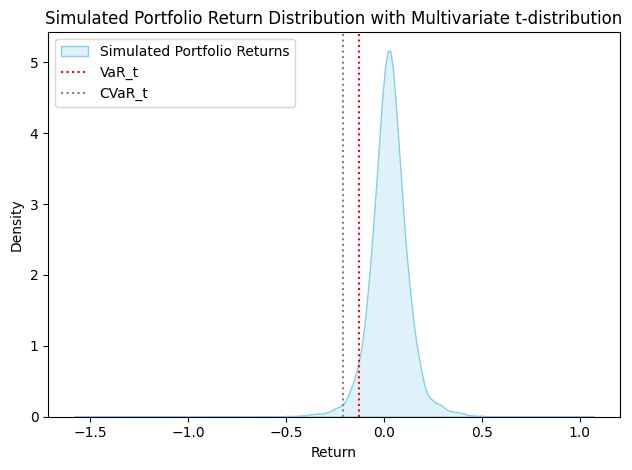

In [ ]:
VaR_mvn = np.percentile(portfolio_returns_normal, (1-confidence_level)*100)
CVaR_mvn = portfolio_returns_normal[portfolio_returns_normal <= VaR_mvn].mean()
print(f"=== Portfolio Risk Metrics with Multivariate t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"VaR_mvn: {VaR_mvn:.4f}")            
print(f"CVaR_mvn: {CVaR_mvn:.4f}")
# Dashboard plot        
x = np.linspace(portfolio_returns_normal.min(), portfolio_returns_normal.max(), 1000)
sns.kdeplot(portfolio_returns_normal, fill=True, color='skyblue', label='Simulated Portfolio Returns')
#plt.plot(x, no.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')
plt.axvline(VaR_mvn, color='red', linestyle=':', label='VaR_mvn')
plt.axvline(CVaR_mvn, color='grey', linestyle=':', label='CVaR_mvn')
plt.title('Simulated Portfolio Return Distribution with Multivariate t-distribution')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

=== Portfolio Risk Metrics with Multivariate t-distribution (95% confidence) ===
VaR_mvn: -0.0908
CVaR_mvn: -0.1206


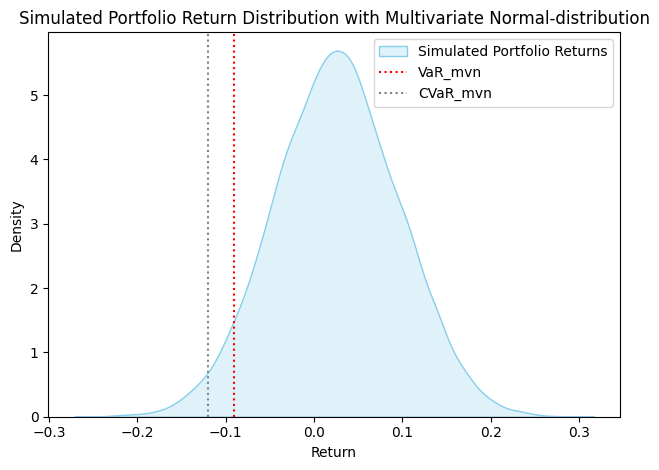

In [68]:
VaR_mvn = np.percentile(portfolio_returns_normal, (1-confidence_level)*100)
CVaR_mvn = portfolio_returns_normal[portfolio_returns_normal <= VaR_mvn].mean()
print(f"=== Portfolio Risk Metrics with Multivariate t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"VaR_mvn: {VaR_mvn:.4f}")            
print(f"CVaR_mvn: {CVaR_mvn:.4f}")
# Dashboard plot        
x = np.linspace(portfolio_returns_normal.min(), portfolio_returns_normal.max(), 1000)
sns.kdeplot(portfolio_returns_normal, fill=True, color='skyblue', label='Simulated Portfolio Returns')
#plt.plot(x, no.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')
plt.axvline(VaR_mvn, color='red', linestyle=':', label='VaR_mvn')
plt.axvline(CVaR_mvn, color='grey', linestyle=':', label='CVaR_mvn')
plt.title('Simulated Portfolio Return Distribution with Multivariate Normal-distribution')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### Both the VaR and CVaR estimates are much lower when incorportating asset correlations. This is probably due to the fact, that when correlated assets fall together(perhaps during crises), they reduce the expected minimal shortfall.

In [73]:
covid_data = yf.download(tickers, start="2020-01-01", end="2020-12-01")['Close']
covid_returns = covid_data.resample('M').last().pct_change().dropna().dot(weights)

covid_returns.values

[*********************100%***********************]  5 of 5 completed
C:\Users\manij\AppData\Local\Temp\ipykernel_63224\2333749089.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  covid_returns = covid_data.resample('M').last().pct_change().dropna().dot(weights)


array([-0.02916087, -0.04340736,  0.16584595,  0.07437365,  0.089479  ,
        0.09725635,  0.15434912, -0.06924916, -0.02075128,  0.07088091])

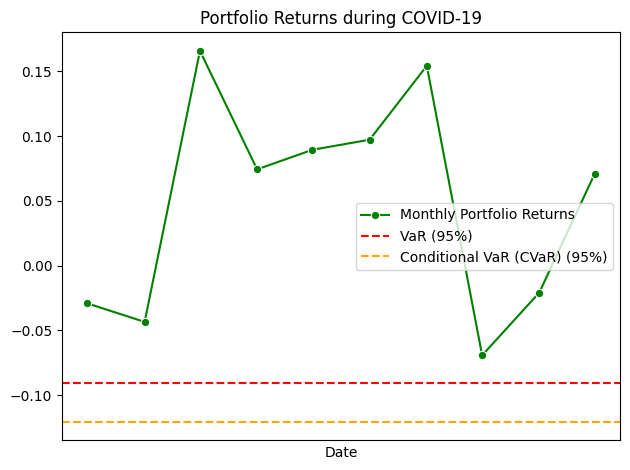

In [87]:
sns.lineplot(data = covid_returns, color = 'green', label='Monthly Portfolio Returns', marker='o')
plt.axhline(y=VaR_mvn, color='red', linestyle='--', label=f'VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=CVaR_mvn, color='orange', linestyle='--', label=f'Conditional VaR (CVaR) ({confidence_level*100:.0f}%)')
plt.title('Portfolio Returns during COVID-19')
plt.xticks([])
plt.legend()
plt.tight_layout()
plt.show()

## If we had this portfolio during COVID, and this model, the losses would never exceed our CVaR or even VaR estimates!

- Downloaded historical price data for a portfolio of large-cap tech stocks (AAPL, MSFT, GOOG, NVDA, AMZN) using yfinance.
- Computed monthly returns and constructed an equally weighted portfolio.
- Visualized the empirical distribution of portfolio returns and compared it to fitted normal and Student's t-distributions.
- Calculated Value at Risk (VaR) and Conditional VaR (CVaR) using historical, parametric (normal and t), and Monte Carlo simulation methods.
- Found that the normal provides a better fit to the empirical return distribution, especially in the tails.
- Analyzed individual stock return distributions and visualized pairwise correlations using pairplots and heatmaps.
- Simulated portfolio returns using both multivariate normal and multivariate t-distributions to account for asset correlations.
- Observed that incorporating asset correlations and fat tails (via the multivariate normal) significantly affects risk metrics, generally increasing estimated risk.
- Compared risk metrics (VaR, CVaR) across all methods and highlighted the importance of modeling both tail distributions and correlations in risk estimation.
- Applied the methodology to COVID-19 period data to observe risk under extreme market conditions.